In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
# section1, 2 で実装したもので必要なもの
from maze import MazeEnv
from agents import Agent
from policies import Policy, Parameters
from optimizers import Optimizer

# 3. 方策最適化に基づく学習アルゴリズム
価値ベースの方法は、「行動空間」`Env.action_space` が巨大すぎる場合などではトレーニングに失敗することがあります。別の選択肢の 1 つは、値 Q(s,a) ではなく、ポリシー $\pi$ 自体のモデルを作成することです。

## 3-1. 状態価値関数、期待収益、方策勾配法
[Section2](https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/section2.ipynb)
では行動価値関数を

$$
Q^\pi(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

としました。これは状態 s で行動 a を取った時の収益の期待値だったわけですが、これを更に a について方策で期待値を取ったもの

$$
V^{\pi}(s) = \langle Q^{\pi}(s, a) \rangle_{a \sim \pi(\cdot|s)}
$$

これは「方策 $\pi$ のもとで状態 s が持っている価値」を表し、**状態価値関数(state value function)** と呼ばれます。更に、迷路の実装を思い出すと

In [3]:
Env = MazeEnv(5,5, 1.2, figsize=3)

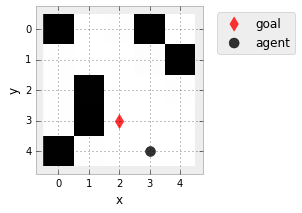

In [4]:
Env.reset()
Env.render()

の**`Env.reset()`**は最初の状態 s をランダムに選んでいるのがわかります。この確率を $P_\text{reset}(s)$ とし、状態価値の期待値を取ると

$$
J(\pi) = \langle V^{\pi}(s) \rangle_{s \sim P_\text{reset} (\cdot)}
$$

となりますが、環境が固定されている以上この量は「方策にしか依存しない量」であり、かつ方策の良さを表す量（大きいほど良い）であると言えるでしょう。これを**期待収益(expected return)**といいます。

### ● 方策勾配法
そこで、価値の推定をすっ飛ばして、この$J(\pi)$を直接最大化する学習が考えられます。そのうちでも最も単純なのが
方策を θ でパラメーター化し

$$
\pi(a|s) = \pi_\theta(a|s)
$$

この時の期待収益を $\theta$ の関数と考え、勾配更新

$$
\theta \leftarrow \theta + \eta \nabla_\theta J(\pi_{\theta})
$$

によって学習を進めてゆくことです。これを**方策勾配法(Policy-gradient method)**といいます。

問題は方策勾配 $\nabla_\theta J(\pi_{\theta})$ をどうやって求めるのか、というところです。

## 3-2. 方策勾配定理とREINFORCEアルゴリズム
ここで少し定義を変更させてください。今までは行動価値観数を

$$
Q^\pi(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

と減衰和にしていましたが、ここからは

$$
Q^\pi(s,a) = 
\lim_{T \to \infty}
\langle \frac{1}{T}\sum_{k=0}^{T-1}  r_{t+1+k} \rangle_{(s_t, a_t)=(s,a)}
$$

と平均和の時間無限大極限に取ることにします。この場合のベルマン方程式は、

$$
Q^\pi(s,a) = \langle
Q^\pi(s_{+1}, a_{+1})
\rangle_{s_{+1} \sim P_s(\cdot|s, a),\ a_{+1} \sim \pi(\cdot | s_{+1})}
$$

となります。これを用いて方策勾配を求めてみましょう。まず状態価値観数の方策勾配から求めると

$$
\left. \begin{array}{rl}
\nabla_\theta \underbrace{ V^{\pi_\theta}(s) }_{\langle Q^{\pi_\theta} (s, a) \rangle_{a \sim \pi_\theta(\cdot|s)}}
&=
\nabla_\theta 
\sum_{a}
Q^{\pi_\theta} (s, a)
\pi_\theta(a|s)
\\
&=
\sum_{a}
\Big(
\underbrace{
\nabla_\theta 
Q^{\pi_\theta} (s, a)
}_{(*)}
\cdot
\pi_\theta(a|s)
+
Q^{\pi_\theta} (s, a)
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a| s)
}_{\big(\nabla_\theta \log \pi_\theta(a | s)\big) \cdot \pi_\theta(a | s)}
\Big)
\\
&=
\sum_{a}
\Big(
(*)
+
Q^{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\Big) \cdot
\pi_\theta(a|s)
\\
&=
\big\langle
(*)
+
Q^{\pi_\theta} (s, a)
\nabla_\theta \log \pi_\theta(a | s)
\big\rangle_{a \sim \pi_\theta(\cdot|s)}
\end{array} \right.
$$

となって、行動価値関数の方策勾配を計算する必要に迫られます。しかしこれはベルマン方程式のため、再帰的に計算でき

$$
\left. \begin{array}{rl}
(*) &= 
\nabla_\theta 
\underbrace{Q^{\pi_\theta} (s, a)}_{Bellman}
\\
&=
\nabla_\theta 
\langle
Q^{\pi_\theta}(s_{+1}, a_{+1})
\rangle_{s_{+1} \sim P_s(\cdot|s, a),\ a_{+1} \sim \pi_\theta(\cdot | s_{+1})}
\\
&=
\nabla_\theta 
\sum_{s_{+1}, a_{+1}}
Q^{\pi_\theta}(s_{+1}, a_{+1})
\pi_\theta(a_{+1} | s_{+1})
P_s(s_{+1}|s, a)
\\
&=
\sum_{s_{+1}, a_{+1}}
\Big(
\underbrace{
\nabla_\theta 
Q^{\pi_\theta}(s_{+1}, a_{+1})
}_{(*)}
\cdot
\pi_\theta(a_{+1} | s_{+1})
+
Q^{\pi_\theta}(s_{+1}, a_{+1})
\cdot
\underbrace{
\nabla_\theta 
\pi_\theta(a_{+1} | s_{+1})
}_{\big(\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})\big) \cdot \pi_\theta(a_{+1} | s_{+1})}
\Big)
P_s(s_{+1}|s, a)
\\
&=
\sum_{s_{+1}, a_{+1}}
\Big(
(*)
+
Q^{\pi_\theta}(s_{+1}, a_{+1})\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})
\Big) \cdot
\pi_\theta(a_{+1} | s_{+1})
P_s(s_{+1}|s, a)
\\
&=
\big\langle
(*)
+
Q^{\pi_\theta}(s_{+1}, a_{+1})\nabla_\theta \log \pi_\theta(a_{+1} | s_{+1})
\big\rangle_{a_{+1} \sim \pi_\theta(\cdot | s_{+1}),\ s_{+1} \sim P_s(\cdot|s, a)}
\\
&=
\Big\langle
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t+1}, a_{t+1})\nabla_\theta \log \pi_\theta(a_{t+1} | s_{t+1})
\Big\rangle_{MDP,\ (s_0, a_0)=(s, a)}
\end{array} \right.
$$

と書け、(*)をもとの V の勾配に代入すると $a_t = a$ として

$$
\nabla_\theta V(s)
=
\Big\langle
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP,\ s_0=s}
$$

更に**期待収益** $J(\pi_\theta)$は、これの初期状態による期待値なので、結局

$$
\nabla_\theta J(\pi_\theta)
=
\Big\langle
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
\Big\rangle_{MDP}
$$

が得られます。これを**方策勾配定理(Policy-gradient theorem)**と言います。

### ● REINFORCEアルゴリズム
実際には、期待値はサンプル$(r_t, s_t, a_t)$によって近似され

$$
\nabla_\theta J(\pi_\theta)
\approx
\sum_{t=0}^\infty
Q^{\pi_\theta}(s_{t}, a_{t})\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
$$

とされますが、ここで結局 $Q^{\pi_\theta}(s_{t}, a_{t})$ が必要になってしまいました。この行動価値関数の意味は、収益の期待値だったわけですので、これを更に報酬のサンプルで適当な T (典型的にはサンプルのエピソード長さが使われる)

$$
Q^{\pi_\theta}(s_{t}, a_{t})
\approx
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}
$$

で近似することが考えられます。これを**REINFORCEアルゴリズム**と言います。すなわち、REINFORCEアルゴリズムとは
1. MDPサンプル$\{(r_t, s_t, a_t)\}_{t=0, 2, \dots, T-1}$を得る
2. $
\theta \leftarrow \theta + \eta g_\theta,\quad \text{where} \
g_\theta = \sum_{t=0}^\infty
\Big(
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}
\Big)
\nabla_\theta \log \pi_\theta(a_{t} | s_{t})
$

を繰り返して、良い方策$\pi_\theta$を探索する手法のことです。
> **【補足】** MDPサンプルは一回の更新につきなるべく多く取ったほうが方策勾配$g_t$の精度が上がります。その場合はエピソード数$m = 0, 1, \dots, M-1$として$g_\theta = 
\frac{1}{M} \sum_{m=0}^{M-1}
\sum_{t=0}^\infty
\Big(
\frac{1}{T} \sum_{k=0}^{T-1} r_{t+1+k}^{(m)}
\Big)
\nabla_\theta \log \pi_\theta(a_{t}^{(m)} | s_{t}^{(m)})$です。

## 3-3. Softmax方策による実装

実際にREINFORCEを実装するにあたって、**Softmax方策**というのを導入します。これは適当な関数 $f(s, a)$ を用いて

$$
\pi_f(a|s)
=
\frac{\exp\{f(s,a)\}}{\sum_{a'} \exp\{
f(s, a')
\}}
$$

とする方策です。[Section2](https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/section2.ipynb)と同様に、$f(s,a)$をパラメータとして

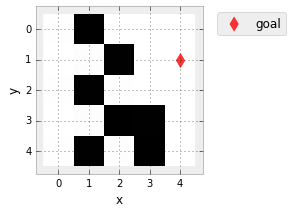

In [20]:
Env = MazeEnv(5,5, figsize=3)
f = Parameters(Env)
Env.render()

と実装してみます。Softmax方策を実装するにあたって、まずsoftmax関数

$$
\text{softmax}\Big(
\begin{pmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3 \\
\end{pmatrix}
\Big)
=
\frac{1}{
\exp\{x_0\}+\exp\{x_1\}+\exp\{x_2\}+\exp\{x_3\}
}
\begin{pmatrix}
\exp\{x_0\} \\
\exp\{x_1\} \\
\exp\{x_2\} \\
\exp\{x_3\} \\
\end{pmatrix}
$$

を実装しておきます：

In [21]:
def softmax(xs):
    sps = xs.shape
    num = np.exp(xs)
    den = np.sum(num, axis=2).reshape(sps[0], sps[1], 1)
    return num/den

こうしておいて、

In [22]:
class Softmax(Policy):
    def __init__(self, Env, f=None, temp=1):
        self.f = f
        self.Env = Env
        self.temp = temp
        
    def get_prob_table(self):
        fvalues_table = self.f.values_table
        #self.f.get_values(state)
        prob = softmax(fvalues_table/self.temp)
        return prob
    
    def get_prob(self, state):
        x, y = state
        return self.get_prob_table()[x, y, :]
        
    def sample(self):
        prob = self.get_prob(self.Env.state)
        action = np.random.choice(self.Env.action_space, p=prob)
               #p=prob のオプションは確率リストprobに従ってaction_spaceからサンプルする
        return action

で良いでしょう。（実装では**温度**`temp`を導入して確率をコントロールできるようにしました）

### ● 迷路の場合のREINFORCEアルゴリズム
迷路の環境では、時刻$t$で
* ゴールしていれば$r_t = 1$
* していなければ$r_t=0$

だったので、1エピソードで共通して方策勾配は

$$
g_\theta
=
\left\{ \begin{array}{ll}
\frac{1}{T} \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta (a_t|s_t) & (\text{if solved}) \\
0 & (\text{if unsolved}) \\
\end{array} \right.
$$

ということになります。この方策勾配はSoftmax方策だともう少し簡単化出来ます。ゴールした場合の勾配にSoftmaxを$\theta=f(s,a)$として代入してみると

$$
\left. \begin{array}{ll}
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{f(s,a)} \log \pi_f (a_t|s_t) 
&=
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{f(s,a)} \log 
\frac{\exp\{f(s_t,a_t)\}}{\sum_{a'} \exp\{
f(s_t, a')
\}}
\\
&=
\frac{1}{T}
\sum_{t=0}^{T-1} \nabla_{f(s,a)} 
\Big(
f(s_t,a_t)
-
\log \sum_{a'} \exp\{
f(s_t, a')
\}
\Big)
\\
&=
\frac{1}{T}
\sum_{t=0}^{T-1} 
\Big(
\overbrace{ \nabla_{f(s,a)} f(s_t, a_t)}^{\delta_{(s,a)=(s_t, a_t)}}
-
\frac{
\sum_{a''}
\overbrace{ \nabla_{f(s,a)} f(s_t, a'')}^{\delta_{(s,a)=(s_t, a'')}}
\cdot
\exp\{
f(s_t, a'')
\}
}{
\sum_{a'} \exp\{
f(s_t, a')
\}
}
\Big)
\\
&=
\frac{1}{T}
\sum_{t=0}^{T-1} 
\Big(
\delta_{(s,a)=(s_t, a_t)}
-
\delta_{s=s_t}
\underbrace{
\frac{
\exp\{
f(s_t, a)
\}
}{
\sum_{a'} \exp\{
f(s_t, a')
\}
}
}_{\pi_f(a|s_t)}
\Big)
\\
&=
\frac{1}{T}\Big(
N_{(s,a)}
-
N_s \pi_f(a|s)
\Big)
\end{array} \right.
$$

となるのがわかります。ここで
* $N_{(s,a)}$:エピソード中に状態 s で行動 a を選んだ回数
* $N_s$:エピソード中に状態 s を取った回数

を表すとします。

In [23]:
class REINFORCE_optimizer(Optimizer):
    def __init__(self, Agt, eta):
        self.Policy = Agt.Policy
        self.f = Agt.Policy.f
        self.Env = Agt.Policy.Env
        self.eta = eta
        self.N_sa = Parameters(self.Env, init=0) # N_{(s,a)}を数えるためParametersを利用
        self.N = 0 # 実際にself.fが更新された回数を数える。なくてもよい
            
    def update(self, s, a, r_next, s_next):
        x, y = s
        if self.Env.is_solved():
            self.N_sa.values_table[x, y, a] +=10 # 最後にボーナス（理論から外れるがこれがないと遅い）
            T = self.Env.t + 0.01 # オーバーフロー対策(たまに偶然ゴールに落とされてしまうので。。。)
            N_sa = self.N_sa.values_table # N_{(s,a)}を読み込む
            N_s = np.sum(N_sa, axis=2).reshape(self.Env.lx, self.Env.ly, 1)
            g = (N_sa - N_s*self.Policy.get_prob_table())/T # 方策勾配
            self.f.values_table += self.eta*g # 更新
            self.N += 1 # なくてもよい
        else:
            self.N_sa.values_table[x, y, a] +=1 # ここは必須、ゴールしてない時はN_{(s,a)}を更新
            
    def reset(self):
        self.N_sa.values_table[:,:,:] = 0*self.N_sa.values_table[:,:,:]
        # エピソードごとにN_{(s,a)}をリセットする。これは下の学習ループで唱える

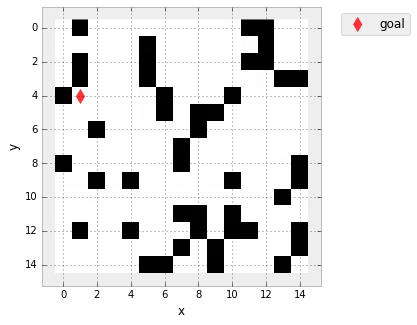

In [24]:
Env = MazeEnv(15,15, 1.2)
Env.render()

In [25]:
%%time
f = Parameters(Env)
Pi=Softmax(Env, f=f, temp=1)
Agt = Agent(Pi)
Opt = REINFORCE_optimizer(Agt, eta=10)
N_episode = 600 # 600でも十分

for episode in range(N_episode):
    Env.reset()
    Opt.reset() # !!! ここ重要　
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        if Env.status=='Moved':
            Opt.update(s, a, r_next, s_next)
        if Env.t > 60: # たまにゴールできない位置に置かれてしまうので
            break

CPU times: user 3.13 s, sys: 8.4 ms, total: 3.14 s
Wall time: 3.14 s


In [27]:
Opt.N # 解けた回数＝実際の更新回数

398

<IPython.core.display.Javascript object>


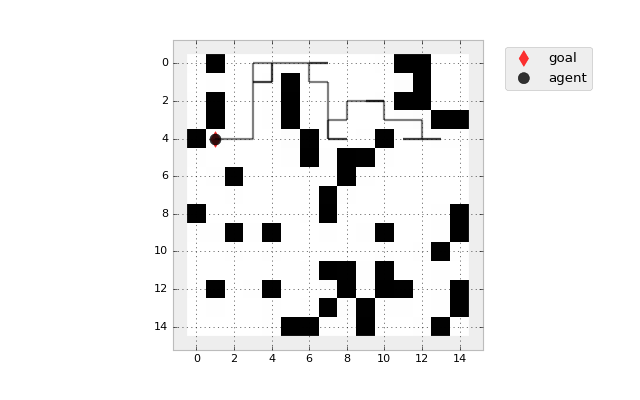

solved!


In [29]:
Env.reset()
%matplotlib notebook 
Env.play_interactive(Agt)
%matplotlib inline

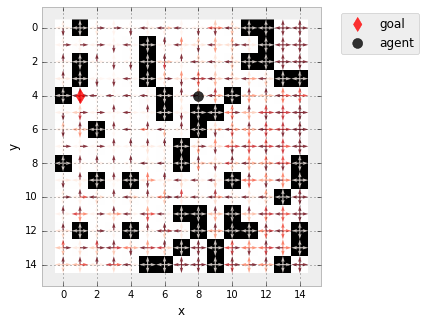

In [30]:
%matplotlib inline
Env.reset()
Env.render(values_table=Pi.get_prob_table())